
# 🚗 Regresión Lineal con Regularización — **Auto MPG** (Scikit-Learn)

Este cuaderno expande el ejemplo de *Regresión Lineal* añadiendo **regularización**:
- **Ridge** (L2): reduce la varianza y encoge coeficientes grandes.
- **Lasso** (L1): además puede llevar algunos coeficientes exactamente a **cero** (selección de variables).

Flujo:

1) Carga y limpieza básica del dataset `mpg`  
2) Preprocesamiento con `OneHotEncoder` para `origin`  
3) Modelos: `LinearRegression`, `RidgeCV`, `LassoCV` (con `StandardScaler`)  
4) Evaluación en *test*: MAE, RMSE, R²  
5) Comparación visual de coeficientes


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## 1) Carga y limpieza

In [ ]:

url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/mpg.csv"
df = pd.read_csv(url)


| Columna          | Significado                                                                                                                                                                  |
| ---------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **mpg**          | *Miles per gallon* — Rendimiento de combustible en millas por galón. Es la **variable objetivo**.                                                                            |
| **cylinders**    | Número de cilindros del motor (4, 6, 8, etc.). Variable categórica numérica.                                                                                                 |
| **displacement** | Cilindrada total del motor en pulgadas cúbicas (*cubic inches*). Relacionada con el tamaño del motor.                                                                        |
| **horsepower**   | Potencia del motor en caballos de fuerza (*horsepower*).                                                                                                                     |
| **weight**       | Peso del vehículo en libras (*pounds*).                                                                                                                                      |
| **acceleration** | Tiempo (en segundos) que tarda el coche en pasar de 0 a 60 mph.                                                                                                              |
| **model\_year**  | Año del modelo (por ejemplo, 70 = 1970, 82 = 1982).                                                                                                                          |
| **origin**       | Región de origen del auto: 1 = USA, 2 = Europa, 3 = Japón.                                                                                                                   |
| **name**         | Nombre y modelo del automóvil (texto libre). Normalmente no se usa directamente como variable de entrada, o se convierte a indicadores de marca/modelo si se quiere incluir. |


In [ ]:
cols_needed = ["mpg","cylinders","displacement","horsepower","weight","acceleration","model_year","origin"]
df = df[cols_needed].dropna().copy()

target = "mpg"
y = df[target].values
num_features = ["cylinders","displacement","horsepower","weight","acceleration","model_year"]
cat_features = ["origin"]
X = df[num_features + cat_features]

## 2) Train/Test split

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape


((313, 7), (79, 7))

## 3) Preprocesamiento

In [ ]:

# One-Hot para la categórica + passthrough numéricas
ohe = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(drop="first", sparse_output=False), cat_features)],
    remainder="passthrough"
)

# Escalado posterior a OHE (para regularización estable)
preprocess = Pipeline(steps=[
    ("ohe", ohe),
    ("scaler", StandardScaler())
])


## 4) Modelos y entrenamiento

In [ ]:

# Lineal sin regularización
lin = Pipeline(steps=[("prep", preprocess),
                     ("model", LinearRegression())])
lin.fit(X_train, y_train)

# Ridge con búsqueda de alpha vía CV
ridge_alphas = np.logspace(-3, 3, 20)
ridge = Pipeline(steps=[("prep", preprocess),
                       ("model", RidgeCV(alphas=ridge_alphas, cv=5))])
ridge.fit(X_train, y_train)

# Lasso con búsqueda de alpha vía CV
lasso = Pipeline(steps=[("prep", preprocess),
                       ("model", LassoCV(alphas=np.logspace(-3, 1, 30), cv=5, max_iter=10000))])
lasso.fit(X_train, y_train)

# Predicciones
y_pred_lin   = lin.predict(X_test)
y_pred_ridge = ridge.predict(X_test)
y_pred_lasso = lasso.predict(X_test)

def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

m_lin   = metrics(y_test, y_pred_lin)
m_ridge = metrics(y_test, y_pred_ridge)
m_lasso = metrics(y_test, y_pred_lasso)

print("MAE | RMSE | R2")
print("Linear:", [round(v,4) for v in m_lin])
print("Ridge :", [round(v,4) for v in m_ridge], "alpha* =", getattr(ridge.named_steps["model"], "alpha_", None))
print("Lasso :", [round(v,4) for v in m_lasso], "alpha* =", getattr(lasso.named_steps["model"], "alpha_", None))


MAE | RMSE | R2
Linear: [2.462, 3.2561, 0.7923]
Ridge : [2.4658, 3.2807, 0.7891] alpha* = 2.976351441631316
Lasso : [2.4746, 3.3042, 0.7861] alpha* = 0.08531678524172806


## 5) Comparación de coeficientes

In [ ]:

# Recuperar nombres de features después de OHE
ohe_fit = preprocess.named_steps["ohe"]
feat_names = list(ohe_fit.named_transformers_["cat"].get_feature_names_out(cat_features)) + num_features

# Extraer coeficientes ya escalados (último paso del pipeline)
coef_lin   = lin.named_steps["model"].coef_
coef_ridge = ridge.named_steps["model"].coef_
coef_lasso = lasso.named_steps["model"].coef_

coef_df = pd.DataFrame({
    "feature": feat_names,
    "Linear": coef_lin,
    "Ridge": coef_ridge,
    "Lasso": coef_lasso,
}).set_index("feature")

# Mostrar tabla ordenada por magnitud en el modelo Ridge
coef_df.loc[coef_df["Ridge"].abs().sort_values(ascending=False).index].head(15)


,Linear,Ridge,Lasso
feature,,,
weight,-5.393692,-4.854288,-4.600721
model_year,2.889178,2.812920,2.745648
displacement,1.989750,1.300622,0.000000
origin_usa,-1.375644,-1.268329,-1.046137
horsepower,-0.826385,-0.914800,-0.430142
cylinders,-0.580795,-0.444248,-0.000000
origin_japan,0.132504,0.195565,0.147758
acceleration,0.118718,0.014014,0.000000


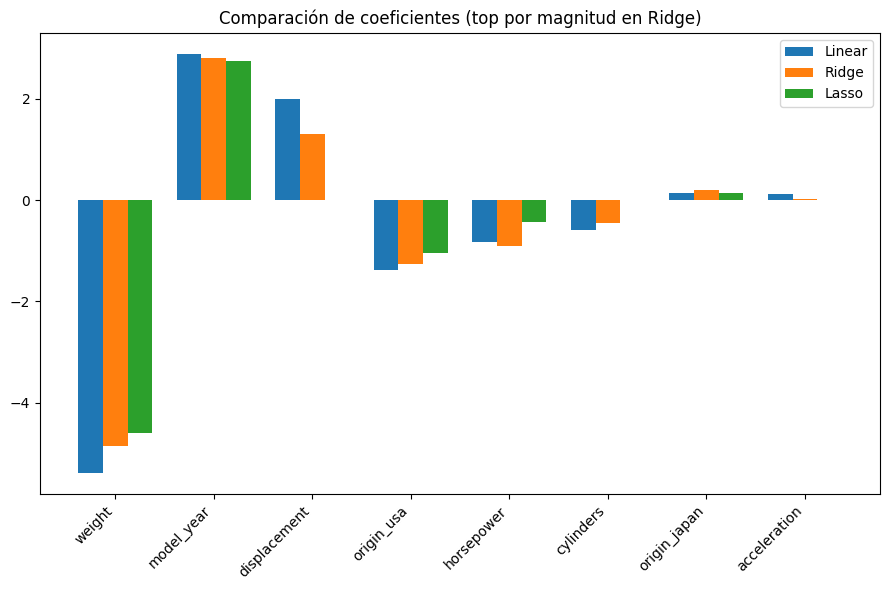

In [ ]:

# Gráfico único de coeficientes comparados (hasta 12 más influyentes por Ridge)
topk = 12
order = coef_df["Ridge"].abs().sort_values(ascending=False).index[:topk]
plot_df = coef_df.loc[order]

plt.figure(figsize=(9,6))
x = np.arange(len(plot_df))
w = 0.25
plt.bar(x - w, plot_df["Linear"].values, width=w, label="Linear")
plt.bar(x,       plot_df["Ridge"].values, width=w, label="Ridge")
plt.bar(x + w, plot_df["Lasso"].values, width=w, label="Lasso")
plt.xticks(x, plot_df.index, rotation=45, ha="right")
plt.title("Comparación de coeficientes (top por magnitud en Ridge)")
plt.legend()
plt.tight_layout()
plt.show()



### 🧠 Cómo interpretar la regularización
- **Ridge (L2):** encoge coeficientes grandes para reducir varianza. Útil cuando hay **multicolinealidad** o muchas variables correlacionadas.  
- **Lasso (L1):** puede forzar algunos coeficientes a **cero** → *selección de variables*.  
- Si el rendimiento de Ridge/Lasso mejora (menor RMSE, mayor \(R^2\)) respecto al lineal, es señal de **mejor generalización**.  
- El valor óptimo de \(\alpha\) se elige por **validación cruzada** (RidgeCV/LassoCV).
